In [1]:
import os
from subprocess import run
from IPython.display import Image, display

In [2]:
def extract_keyframes(input_file, 
                      output_dir=None,
                      file_name=None,
                      cutoff=0.4,
                      step=0.8,
                      iterations=24,
                      min_frames=2,
                      max_frames=12):

    # Raise error if input file doesn't exist
    if not os.path.isfile(input_file):
        print(f"ERROR: File '{input_file}' cannot be opened.")
        return None

    # Set default output directory if not provided
    output_dir = output_dir or f"{input_file}-keyframes/"

    # Clear or create output directory
    if os.path.isdir(output_dir):
        for f in os.listdir(output_dir):
            os.unlink(os.path.join(output_dir, f))
        os.rmdir(output_dir)
    os.makedirs(output_dir)

    # Set default file name
    if file_name is None:
        print("Setting default filename...")
        file_name = os.path.splitext(os.path.basename(input_file))[0]

    # Nested functions (minimal change)
    def keyframes(cutoff, iterations):
        if iterations == 0:
            print("ERROR: Stopped trying; increase iterations parameter to try more!")
            return None
        command = f"""ffmpeg -i "{input_file}" -vf "select='gt(scene,{cutoff})'" -vsync 0 "{output_dir}{file_name}-%02d.jpg" """
        print(f"Running: {command}")
        result = run(command, shell=True, capture_output=True)
        if result.returncode != 0:
            print(f"ffmpeg error: {result.stderr.decode().strip()}")
            return keyframes(cutoff * step, iterations - 1)
        else:
            return countcontrol(cutoff, iterations)

    def countcontrol(cutoff, iterations):
        n = len(os.listdir(output_dir))
        print(f"Found {n} keyframes.")
        if n < min_frames:
            print("Too few keyframes, let's try again!")
            return keyframes(cutoff * step, iterations - 1)
        elif n > max_frames:
            print("Too many keyframes, let's try again")
            return keyframes(cutoff * (1 + step/2), iterations - 1) # added the lower stepsize for max
        else:
            print(f"Solution found! Check {output_dir} directory.")
            return striphorizontal()

    def striphorizontal():
        combined_img = f"{output_dir}{file_name}-keyframes.jpg"
        command = f"""convert +append "{output_dir}"*.jpg "{combined_img}" """
        print(f"Combining keyframes: {command}")
        result = run(command, shell=True)
        if result.returncode == 0:
            print(f"Keyframes have been saved in a single file under: {combined_img}")
            #display(Image(combined_img))
            return combined_img
        else:
            print("Error combining keyframes. Make sure ImageMagick is installed.")

    # Begin processing
    return keyframes(cutoff, iterations)


Setting default filename...
Running: ffmpeg -i "1.mov" -vf "select='gt(scene,0.4)'" -vsync 0 "1.mov-keyframes/1-%02d.jpg" 
Found 0 keyframes.
Too few keyframes, let's try again!
Running: ffmpeg -i "1.mov" -vf "select='gt(scene,0.32000000000000006)'" -vsync 0 "1.mov-keyframes/1-%02d.jpg" 
Found 0 keyframes.
Too few keyframes, let's try again!
Running: ffmpeg -i "1.mov" -vf "select='gt(scene,0.25600000000000006)'" -vsync 0 "1.mov-keyframes/1-%02d.jpg" 
Found 0 keyframes.
Too few keyframes, let's try again!
Running: ffmpeg -i "1.mov" -vf "select='gt(scene,0.20480000000000007)'" -vsync 0 "1.mov-keyframes/1-%02d.jpg" 
Found 0 keyframes.
Too few keyframes, let's try again!
Running: ffmpeg -i "1.mov" -vf "select='gt(scene,0.16384000000000007)'" -vsync 0 "1.mov-keyframes/1-%02d.jpg" 
Found 0 keyframes.
Too few keyframes, let's try again!
Running: ffmpeg -i "1.mov" -vf "select='gt(scene,0.13107200000000005)'" -vsync 0 "1.mov-keyframes/1-%02d.jpg" 
Found 0 keyframes.
Too few keyframes, let's try

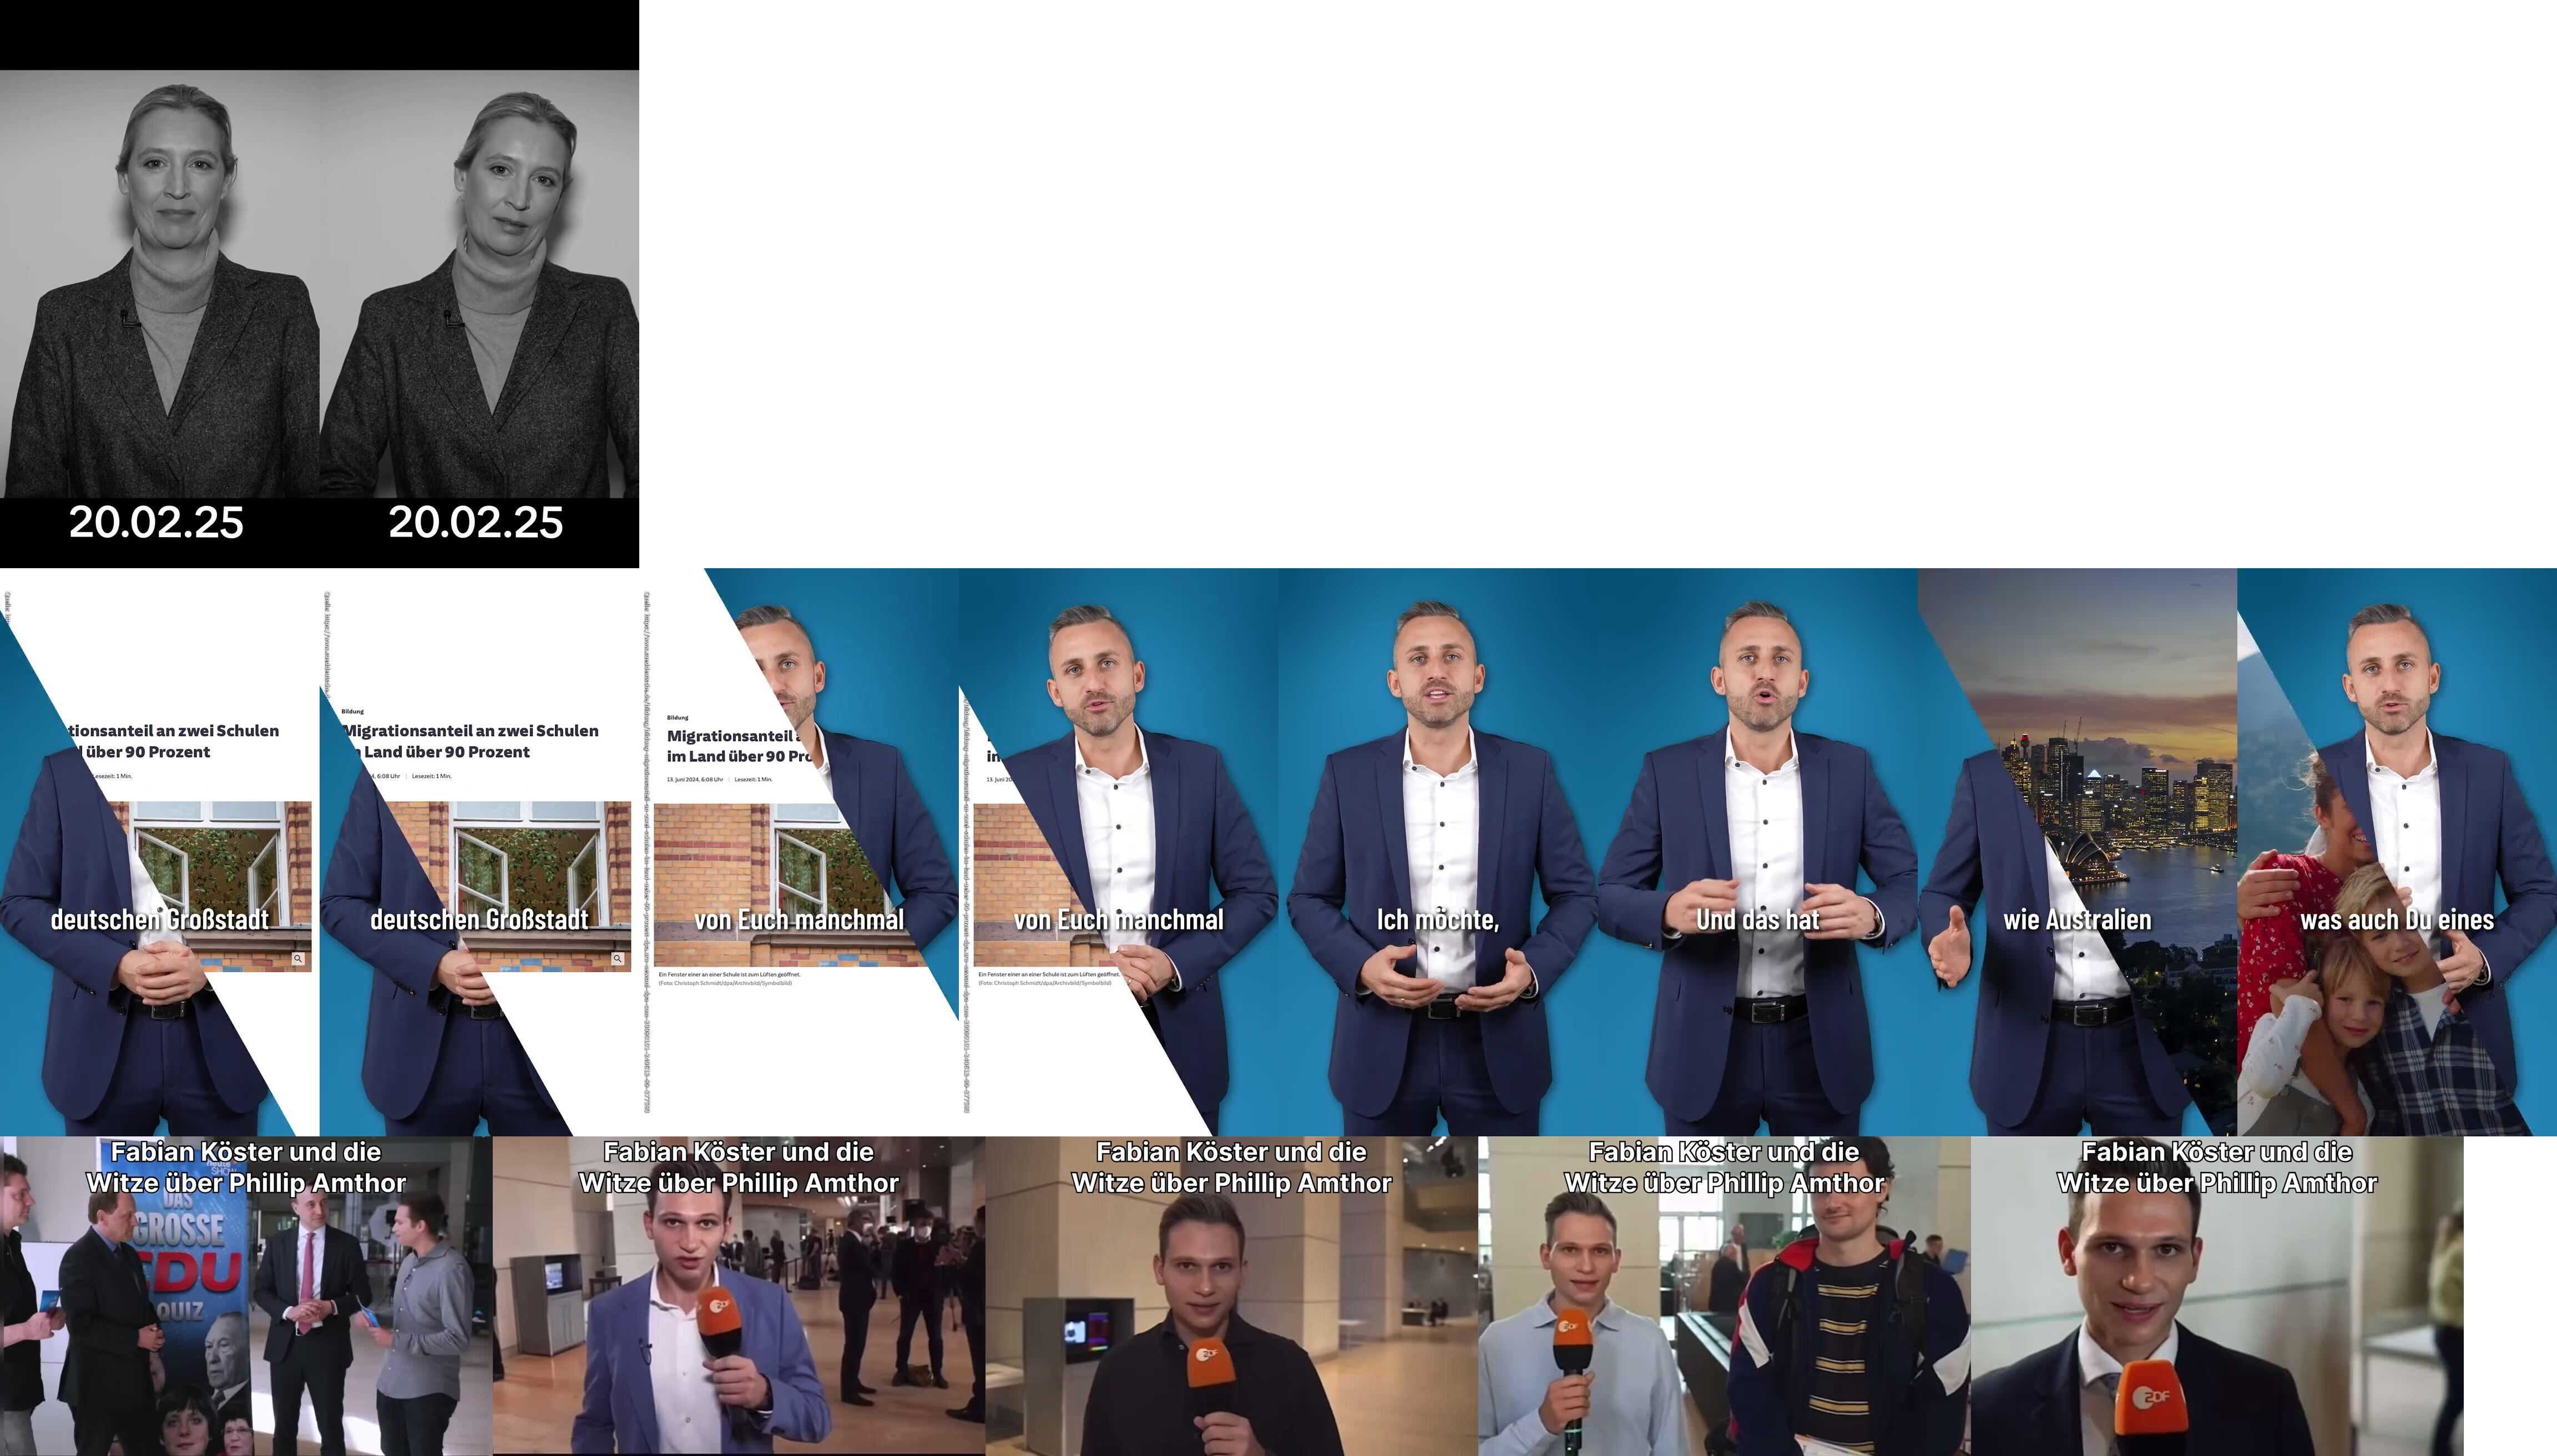

In [3]:
movies = ["1.mov", "2.mov", "3.mov"]

combined_images = []

for movie in movies:
    keyframes = extract_keyframes(movie)
    if keyframes:
        combined_images.append(keyframes)

if combined_images:
    final_combined_image = "all_movies_keyframes.jpg"
    combined_paths = ' '.join(f'"{img}"' for img in combined_images)
    final_command = f"convert -append {combined_paths} {final_combined_image}"
    print(f"Running: {final_command}")
    result = run(final_command, shell=True)
    if result.returncode == 0:
        print(f"Combined all movies successfully into '{final_combined_image}'")
        display(Image(final_combined_image))
    else:
        print("Error combining all movies into one image.")
